# Part 1

In [67]:
import qiskit
from qiskit import quantum_info
from qiskit.execute_function import execute
from qiskit import BasicAer
import numpy as np
import pickle
import json
import os
from collections import Counter
from sklearn.metrics import mean_squared_error
from typing import Dict, List
import matplotlib.pyplot as plt
import cv2

#define utility functions

def simulate(circuit: qiskit.QuantumCircuit) -> dict:
    """Simulate the circuit, give the state vector as the result."""
    backend = BasicAer.get_backend('statevector_simulator')
    job = execute(circuit, backend)
    result = job.result()
    state_vector = result.get_statevector()
    
    histogram = dict()
    for i in range(len(state_vector)):
        population = abs(state_vector[i]) ** 2
        if population > 1e-9:
            histogram[i] = population
    
    return histogram


def histogram_to_category(histogram):
    """This function take a histogram representations of circuit execution results, and process into labels as described in 
    the problem description."""
    assert abs(sum(histogram.values())-1)<1e-8
    positive=0
    for key in histogram.keys():
        digits = bin(int(key))[2:].zfill(20)
        if digits[-1]=='0':
            positive+=histogram[key]
        
    return positive


def count_gates(circuit: qiskit.QuantumCircuit) -> Dict[int, int]:
    """Returns the number of gate operations with each number of qubits."""
    counter = Counter([len(gate[1]) for gate in circuit.data])
    #feel free to comment out the following two lines. But make sure you don't have k-qubit gates in your circuit
    #for k>2
    for i in range(2,20):
        assert counter[i]==0
        
    return counter


def image_mse(image1,image2):
    # Using sklearns mean squared error:
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
    return mean_squared_error(image1, image2)

# Part 2

In [3]:
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit import QuantumCircuit, Aer
from qiskit.circuit import Parameter, ParameterVector
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

%matplotlib inline

In [5]:
def amplitude_encode(img_data):
    
    # Calculate the RMS value
    rms = np.sqrt(np.sum(np.sum(img_data**2, axis=1)))
    
    # Create normalized image
    image_norm = []
    for arr in img_data:
        for ele in arr:
            image_norm.append(ele / rms)
        
    # Return the normalized image as a numpy array
    return np.array(image_norm)

In [6]:

def preprocess_image(images):
    images_norm = []
    for i in range(images.shape[0]):
        im = cv2.resize(images[i], dsize=(16, 16))
        norm = amplitude_encode(im)
        images_norm.append(norm)
    return np.stack(images_norm, axis=0)
preprocess_images = preprocess_image(images)
preprocess_images.shape

(2000, 256)

In [7]:
labels = np.array(labels*1)
print(np.unique(labels, return_counts=True))

(array([0, 1]), array([1500,  500]))


In [8]:
def filter_data(x, y):
    x_filtered = []
    y_filtered = []
    for i in range(2):
        keep = (y == i)
        x_i, y_i = x[keep], y[keep]

        
        x_i = x_i[:20]
        y_i = y_i[:20]

        x_filtered.append(x_i)
        y_filtered.append(y_i)

    

    return np.concatenate(x_filtered, axis=0), np.concatenate(y_filtered, axis=0)

x_filtered, y_filtered = filter_data(preprocess_images, labels)
print(x_filtered.shape)
print(np.unique(y_filtered, return_counts=True))

(40, 256)
(array([0, 1]), array([20, 20]))


In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_filtered, y_filtered, test_size=0.2, shuffle=True, random_state=0)
print(X_train.shape)
print(X_test.shape)
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

(32, 256)
(8, 256)
(array([0, 1]), array([16, 16]))
(array([0, 1]), array([4, 4]))


In [10]:
def encode_image_part2():
    # NOTE: can actually resize the image to make it larger i.e. use n = 32
    # n = 16

    # im = cv2.resize(image, dsize=(n, n))

    # image_norm = amplitude_encode(im)
    data_qb = 8  # math.log2(n*n)
    anc_qb = 1
    total_qb = data_qb + anc_qb

    # Initialize the amplitude permutation unitary
    D2n_1 = np.roll(np.identity(2**total_qb), 1, axis=1)

    ancilla = qiskit.QuantumCircuit(1)
    amp_cir = RawFeatureVector(256)
    
    qc = qiskit.QuantumCircuit(total_qb)
    qc.append(ancilla.to_instruction(), list(range(1)))
    qc.append(amp_cir.to_instruction(), list(range(1, total_qb)))
   
    # qc.initialize(image, range(1, total_qb))
    qc.h(0)
    qc.unitary(D2n_1, range(total_qb))
    qc.h(0)
    # display(qc.draw('mpl', fold=-1))
    return qc

In [25]:
import itertools

# def entangler(bits, entangling_arrangement="chain", type_entangles="cnot"):
#         circuit = qiskit.QuantumCircuit(bits)
#         if entangling_arrangement == "chain":
#             index = [[2 * j, 2 * j + 1] for j in range(bits // 2)] + [
#                 [2 * j + 1, 2 * j + 2] for j in range((bits - 1) // 2)]
#         elif entangling_arrangement == "all":
#             index = list(itertools.chain(*[[np.random.permutation([i, j]) for j in range(i + 1, bits)] for i in range(bits) - 1)]))
#         for this_bits, next_bits in index:
#             if this_bits < next_bits:
#                 a = this_bits
#                 b = next_bits
#             else:
#                 a = next_bits
#                 b = this_bits
#             if type_entangles == 'cnot':
#                 circuit.cnot(bits[a], bits[b])
#             elif type_entangles == 'cphase':
#                 circuit.cp(np.pi, bits[a], bits[b])
#         return circuit

def layerX(bits, params=None, gen_params=None):
        """
        if params = None, a gen_params function should be used
        """
        circuit = qiskit.QuantumCircuit(bits)
        for i, qubit in enumerate(range(bits)):
            if len(params)==0:
                if gen_params == None:
                    raise ValueError("gen_params function is None. Should pass a param generating function")
                circuit.rx(gen_params(learning_params), qubit)
            else:
                circuit.rx(params[i], qubit)
        return circuit

def layerY(bits, params=None, gen_params=None):
        """
        if params = None, a gen_params function should be used
        """
        circuit = qiskit.QuantumCircuit(bits)
        for i, qubit in enumerate(range(bits)):
            if len(params)==0:
                if gen_params == None:
                    raise ValueError("gen_params function is None. Should pass a param generating function")
                circuit.ry(gen_params(learning_params), qubit)
            else:
                circuit.ry(params[i], qubit)
        return circuit

def layerZ(bits, params=None, gen_params=None):
        """
        if params = None, a gen_params function should be used
        """
        circuit = qiskit.QuantumCircuit(bits)
        for i, qubit in enumerate(range(bits)):
            if len(params)==0:
                if gen_params == None:
                    raise ValueError("gen_params function is None. Should pass a param generating function")
                circuit.rz(gen_params(learning_params), qubit)
            else:
                circuit.rz(params[i], qubit)
        return circuit

def _get_new_param(learning_params):
        new_param = Parameter("p" + str(len(learning_params)))
        learning_params.append(new_param)
        return new_param
        

def classifier_cir(bits, gen_params=None, params=[]):
    circuit = qiskit.QuantumCircuit(bits)
    for i in range(0,6,2):
        circuit.append(layerX(bits,params=params[i*(bits):(i+1)*(bits)] ,gen_params=gen_params).to_instruction(), list(range((bits))))
        circuit.append(layerZ(bits, params=params[(i+1)*(bits):(i+2)*(bits)],gen_params=gen_params).to_instruction(), list(range((bits))))
        for i in range(bits-1):
            circuit.cnot(i, i+1)  
    return circuit

In [26]:
# Define Optimizer
import numpy as np

def SPSA_gradient(loss, currentParams, gradientCoefficient):
    r'''Computes an estimator of the gradient using the procedure
    described in the SPSA algorithm.
    
    Inputs:
        loss: The loss function
        currentParams: The current value for the parameters
        gradientCoefficient: The coefficient c_n, which controls how much the current parameters are
                                               perturbed when computing the gradient
    
    Returns:
        gradient: The SPSA-based gradient of the loss function at currentParams'''
    
    numParams = len(currentParams)
    # Generate a random perturbation using the Rademacher distribution
    randomPerturbation = 2*np.random.binomial(1, .5, size=numParams) - 1
    
    gradient = (loss(currentParams + gradientCoefficient*randomPerturbation) - loss(currentParams - gradientCoefficient*randomPerturbation))\
                        /(gradientCoefficient*randomPerturbation)
    
    return gradient

def SPSA_update(loss, currentParams, updateCoefficient, gradientCoefficient):
    r'''Performs a parameter update according to the SPSA approach.
    
    NOTE: This function isn't aware of the notion of iterations, or anything of that sort.
    
    Inputs:
        loss: The loss function
        currentParams: The current value for the parameters
        updateCoefficient: The coefficient a_n, which controls how the current parameters are updated
                                            when including the gradient
        gradientCoefficient: The coefficient c_n, which controls how much the current parameters are
                                               perturbed when computing the gradient
    Returns:
        The updated parameter values'''
    
    grad = SPSA_gradient(loss, currentParams, gradientCoefficient)
    
    return currentParams - updateCoefficient*grad

In [27]:
y_train

array([0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 0])

In [29]:
def loss(params, dataCircuits):

    qcs = [d.bind_parameters(dict(zip(learning_params, params)))for d in dataCircuits]
    prediction_loss = 0
    

    job = execute(qcs, backend)
    results = job.result()
    
    state_vectors = [results.get_statevector(i) for i in range(len(X_train))]
    print(len(list(state_vectors)))
    for k,state_vector in enumerate(list(state_vectors)): 
        histogram = dict()
        for i in range(len(state_vector)):
            population = abs(state_vector[i]) ** 2
            if population > 1e-9:
                histogram[i] = population
        
        positive=0
        for key in histogram.keys():
            digits = bin(int(key))[2:].zfill(20)
            if digits[-1]=='0':
                positive+=histogram[key]
        if positive > 0.5:
            prediction = 1
        else:
            prediction = 0
        
        prediction_loss += np.abs(y_train[k] - prediction)**2

    return prediction_loss
    


In [30]:
import qiskit
from qiskit import quantum_info
from qiskit.execute_function import execute
from qiskit import BasicAer
import numpy as np
import pickle
import json
import os
from collections import Counter
from sklearn.metrics import mean_squared_error
from typing import Dict, List

c = 1
a = c/5



lossList = []
cList = []
aList = []
paramsList = []


learning_params = ParameterVector("param", length=54)
currentParams = np.random.uniform(-np.pi, np.pi, size=54)
backend = BasicAer.get_backend('statevector_simulator')
for j in range(10):
    print(j)
    cj = c/(j+1)**(1/3)
    aj = a/(j+1)
    aList.append(aj)
    cList.append(cj)

    np.random.seed(j)
    
    circuit=encode_image_part2()
        
    classifier = classifier_cir(9, params=learning_params)
    
    
    #append with classifier circuit
    nq1 = circuit.width()
    nq2 = classifier.width()
    nq = max(nq1, nq2)
    qc = qiskit.QuantumCircuit(nq)
    qc.append(circuit.to_instruction(), list(range(nq1)))
    qc.append(classifier.to_instruction(), list(range(nq2)))

    input_params = qc.parameters[54:]

    dataCircuits = [qc.bind_parameters(dict(zip(input_params, x))) for x in X_train]


    L = lambda x: loss(x, dataCircuits)

    lossList.append(L(currentParams))

    # Update the parameters
    currentParams = SPSA_update(L, currentParams, aj, cj)     

    paramsList.append(currentParams)

lossList.append(L(currentParams))

0
32
32
32
1
32
32
32
2
32
32
32
3
32
32
32
4
32
32
32
5
32
32
32
6
32
32
32
7
32
32
32
8
32
32
32
9
32
32
32
32


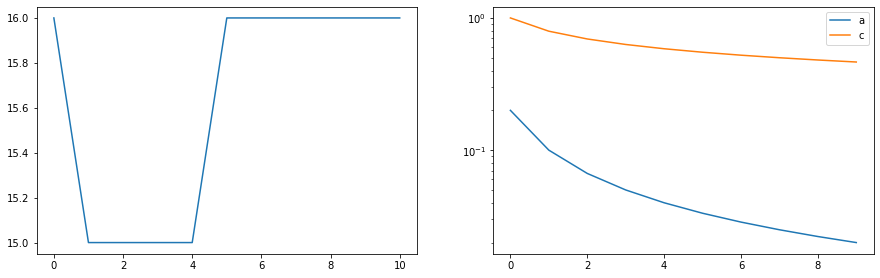

In [31]:
fig = plt.figure(figsize=(15, 10))

ax = fig.add_subplot(2, 2, 1)
ax.plot(lossList)

ax = fig.add_subplot(2, 2, 2)
ax.plot(aList, label='a')
ax.plot(cList, label='c')
ax.legend(loc=0)
ax.set_yscale('log')

# ax = fig.add_subplot(2, 2, 4)
# for j in range(len(paramsList[0])):
#     ax.plot([p[j] for p in paramsList], label='t{0}'.format(j))
ax.legend(loc=0)

In [36]:
score=0
for image, label in zip(preprocess_images[100:110], labels[100:110]):
    circuit=encode_image_part2()
        
    classifier = classifier_cir(9, params=learning_params)
    
    
    #append with classifier circuit
    nq1 = circuit.width()
    nq2 = classifier.width()
    nq = max(nq1, nq2)
    qc = qiskit.QuantumCircuit(nq)
    qc.append(circuit.to_instruction(), list(range(nq1)))
    qc.append(classifier.to_instruction(), list(range(nq2)))
    
    # print(qc.parameters)
    params = np.concatenate((currentParams,image))
    #print(len(params))
    qc = qc.assign_parameters(params)

    job = execute(qc, backend)
    result = job.result()
    state_vector = result.get_statevector()
    histogram = dict()
    for i in range(len(state_vector)):
        population = abs(state_vector[i]) ** 2
        if population > 1e-9:
            histogram[i] = population
    #print(histogram)
    positive=0
    for key in histogram.keys():
        digits = bin(int(key))[2:].zfill(20)
        if digits[-1]=='0':
            positive+=histogram[key]
    print(positive)
    if positive > 0.45:
        prediction = 1
    else:
        prediction = 0
    if prediction == label:
        score+=1
    

print(score)

0.4523034755595777
0.45409521268288733
0.45195231096857663
0.4616509565695604
0.4760756440291836
0.4620685079902045
0.4745035986051802
0.47284522200080076
0.46135213254897084
0.4651169529628585
10


In [40]:
classifier = classifier_cir(9, params=currentParams)
classifier.qasm(filename="quantum_classifier.qasm")

'OPENQASM 2.0;\ninclude "qelib1.inc";\ngate circuit_1849638 q0,q1,q2,q3,q4,q5,q6,q7,q8 { rx(-0.9579188321556569) q0; rx(2.5798997121421117) q1; rx(1.6810582118257462) q2; rx(1.5541843088559142) q3; rx(0.555685834108752) q4; rx(2.181302870448188) q5; rx(-1.5199761642639953) q6; rx(3.6337573151739795) q7; rx(1.5486559214426172) q8; }\ngate circuit_1849641 q0,q1,q2,q3,q4,q5,q6,q7,q8 { rz(0.40301834083518145) q0; rz(0.605137425927762) q1; rz(1.3093771823332239) q2; rz(1.599711539409238) q3; rz(1.5019275915951134) q4; rz(-3.823084983530517) q5; rz(-1.321968164969867) q6; rz(-4.142381762947663) q7; rz(3.3177371735127883) q8; }\ngate circuit_1849644 q0,q1,q2,q3,q4,q5,q6,q7,q8 { rx(0.5755354577505529) q0; rx(3.4970298462527287) q1; rx(4.179422688573913) q2; rx(3.1518436481138172) q3; rx(0.885792741974075) q4; rx(3.127239921502026) q5; rx(-3.663075641578788) q6; rx(-0.15622717180556372) q7; rx(-0.9762542615816036) q8; }\ngate circuit_1849647 q0,q1,q2,q3,q4,q5,q6,q7,q8 { rz(1.5293140833416266) q

In [41]:
classifier=qiskit.QuantumCircuit.from_qasm_file('quantum_classifier.qasm')
classifier.draw()

┌──────────────────┐┌──────────────────┐                              »
q_0: ┤0                 ├┤0                 ├──■───────────────────────────»
     │                  ││                  │┌─┴─┐                         »
q_1: ┤1                 ├┤1                 ├┤ X ├──■──────────────────────»
     │                  ││                  │└───┘┌─┴─┐                    »
q_2: ┤2                 ├┤2                 ├─────┤ X ├──■─────────────────»
     │                  ││                  │     └───┘┌─┴─┐               »
q_3: ┤3                 ├┤3                 ├──────────┤ X ├──■────────────»
     │                  ││                  │          └───┘┌─┴─┐          »
q_4: ┤4 circuit_1849638 ├┤4 circuit_1849641 ├───────────────┤ X ├──■───────»
     │                  ││                  │               └───┘┌─┴─┐     »
q_5: ┤5                 ├┤5                 ├────────────────────┤ X ├──■──»
     │                  ││                  │                    └───┘┌─┴─┐»
q_6: ┤6                 ├┤6                 ├─────────────────────────┤ X ├»
     │                  ││                  │                         └───┘»
q_7: ┤7                 ├┤7                 ├──────────────────────────────»
     │                  ││                  │                              »
q_8: ┤8                 ├┤8                 ├──────────────────────────────»
     └──────────────────┘└──────────────────┘                              »
«               ┌──────────────────┐┌──────────────────┐                    »
«q_0: ──────────┤0                 ├┤0                 ├──■─────────────────»
«               │                  ││                  │┌─┴─┐               »
«q_1: ──────────┤1                 ├┤1                 ├┤ X ├──■────────────»
«               │                  ││                  │└───┘┌─┴─┐          »
«q_2: ──────────┤2                 ├┤2                 ├─────┤ X ├──■───────»
«               │                  ││                  │     └───┘┌─┴─┐     »
«q_3: ──────────┤3                 ├┤3                 ├──────────┤ X ├──■──»
«               │                  ││                  │          └───┘┌─┴─┐»
«q_4: ──────────┤4 circuit_1849644 ├┤4 circuit_1849647 ├───────────────┤ X ├»
«               │                  ││                  │               └───┘»
«q_5: ──────────┤5                 ├┤5                 ├────────────────────»
«               │                  ││                  │                    »
«q_6: ──■───────┤6                 ├┤6                 ├────────────────────»
«     ┌─┴─┐     │                  ││                  │                    »
«q_7: ┤ X ├──■──┤7                 ├┤7                 ├────────────────────»
«     └───┘┌─┴─┐│                  ││                  │                    »
«q_8: ─────┤ X ├┤8                 ├┤8                 ├────────────────────»
«          └───┘└──────────────────┘└──────────────────┘                    »
«                         ┌──────────────────┐┌──────────────────┐          »
«q_0: ────────────────────┤0                 ├┤0                 ├──■───────»
«                         │                  ││                  │┌─┴─┐     »
«q_1: ────────────────────┤1                 ├┤1                 ├┤ X ├──■──»
«                         │                  ││                  │└───┘┌─┴─┐»
«q_2: ────────────────────┤2                 ├┤2                 ├─────┤ X ├»
«                         │                  ││                  │     └───┘»
«q_3: ────────────────────┤3                 ├┤3                 ├──────────»
«                         │                  ││                  │          »
«q_4: ──■─────────────────┤4 circuit_1849650 ├┤4 circuit_1849653 ├──────────»
«     ┌─┴─┐               │                  ││                  │          »
«q_5: ┤ X ├──■────────────┤5                 ├┤5                 ├──────────»
«     └───┘┌─┴─┐          │                  ││                  │          »
«q_6: ─────┤ X ├──■───────┤6                 ├

In [ ]:
def encode_image(image):
    # NOTE: can actually resize the image to make it larger i.e. use n = 32
    # n = 16

    # im = cv2.resize(image, dsize=(n, n))

    # image_norm = amplitude_encode(im)
    data_qb = 8  # math.log2(n*n)
    anc_qb = 1
    total_qb = data_qb + anc_qb

    # Initialize the amplitude permutation unitary
    D2n_1 = np.roll(np.identity(2**total_qb), 1, axis=1)

    qc = qiskit.QuantumCircuit(total_qb)
    # amp_cir = RawFeatureVector(256)

    # qc = qiskit.QuantumCircuit(total_qb)
    # qc.append(ancilla.to_instruction(), list(range(1)))
    # qc.append(amp_cir.to_instruction(), list(range(1, total_qb)))

    qc.initialize(image, range(1, total_qb))
    qc.h(0)
    qc.unitary(D2n_1, range(total_qb))
    qc.h(0)
    # display(qc.draw('mpl', fold=-1))
    return qc

In [53]:
score=0
for image, label in zip(preprocess_images[1500:1510], labels[1500:1510]):
    circuit=encode_image(image)
        
    classifier=qiskit.QuantumCircuit.from_qasm_file('quantum_classifier.qasm')
    
    
    #append with classifier circuit
    nq1 = circuit.width()
    nq2 = classifier.width()
    nq = max(nq1, nq2)
    qc = qiskit.QuantumCircuit(nq)
    qc.append(circuit.to_instruction(), list(range(nq1)))
    qc.append(classifier.to_instruction(), list(range(nq2)))
    
    print(qc.parameters)

    job = execute(qc, backend)
    result = job.result()
    state_vector = result.get_statevector()
    histogram = dict()
    for i in range(len(state_vector)):
        population = abs(state_vector[i]) ** 2
        if population > 1e-9:
            histogram[i] = population
    #print(histogram)
    positive=0
    for key in histogram.keys():
        digits = bin(int(key))[2:].zfill(20)
        if digits[-1]=='0':
            positive+=histogram[key]
    print(positive)
    if positive > 0.45:
        prediction = 1
    else:
        prediction = 0
    if prediction == label:
        score+=1
    

print(score)

ParameterView([])
0.43803850637327973
ParameterView([])
0.4390462079760829
ParameterView([])
0.430925224153573
ParameterView([])
0.490286345204553
ParameterView([])
0.4252268442130466
ParameterView([])
0.4236456739791059
ParameterView([])
0.43515179331576137
ParameterView([])
0.4259233896913271
ParameterView([])
0.4280910887761105
ParameterView([])
0.43713946007520754
9


In [55]:
qc.draw()

┌──────────────────┐┌──────────────────┐
q_0: ┤0                 ├┤0                 ├
     │                  ││                  │
q_1: ┤1                 ├┤1                 ├
     │                  ││                  │
q_2: ┤2                 ├┤2                 ├
     │                  ││                  │
q_3: ┤3                 ├┤3                 ├
     │                  ││                  │
q_4: ┤4 circuit-1884091 ├┤4 circuit-1884098 ├
     │                  ││                  │
q_5: ┤5                 ├┤5                 ├
     │                  ││                  │
q_6: ┤6                 ├┤6                 ├
     │                  ││                  │
q_7: ┤7                 ├┤7                 ├
     │                  ││                  │
q_8: ┤8                 ├┤8                 ├
     └──────────────────┘└──────────────────┘

In [58]:
count_gates(classifier)[2]

24